# Step 5: Using sklearn's decision tree regressor and random forest regressor for comparison with my algorithms made from scratch

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from helper_functions import (
    calculate_mse, calculate_rmse, calculate_mae, calculate_r2, regression_metrics,
    plot_distribution,
    plot_actual_vs_predicted,
    plot_summary_statistics,
    plot_histograms_parallel,
    plot_histograms_stacked
)

In [2]:
current_dir = os.getcwd()
dir_contents = os.listdir(current_dir)

for filename in dir_contents:
    file_path = os.path.join(current_dir, filename)
    if os.path.isfile(file_path):
        print(filename)

creating_dataframe.ipynb
data_analysis.ipynb
data_preprocessing.ipynb
dt_and_rf_from_scratch.ipynb
helper_functions.py
sklearn_dt_and_rf.ipynb


In [3]:
df = pd.read_csv('../dataset/failed_hdds_with_rul.csv')

In [4]:
df.shape

(18588, 31)

In [5]:
df.head()

,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_3_normalized,smart_3_raw,smart_4_normalized,smart_4_raw,smart_5_normalized,smart_5_raw,...,smart_193_raw,smart_194_normalized,smart_194_raw,smart_197_normalized,smart_197_raw,smart_198_normalized,smart_198_raw,smart_199_normalized,smart_199_raw,date_diff_days
0,4000787030016,0,119.0,208663312.0,92.0,0.0,100.0,9.0,100.0,0.0,...,7273.0,23.0,23.0,100.0,0.0,100.0,0.0,200.0,0.0,26
1,12000138625024,0,79.0,155920208.0,98.0,0.0,100.0,2.0,100.0,24.0,...,633.0,40.0,40.0,100.0,88.0,100.0,88.0,200.0,0.0,26
2,8001563222016,0,77.0,54823024.0,98.0,0.0,100.0,2.0,100.0,0.0,...,14936.0,29.0,29.0,100.0,0.0,100.0,0.0,200.0,0.0,52
3,12000138625024,0,84.0,235330528.0,94.0,0.0,100.0,5.0,100.0,0.0,...,1501.0,25.0,25.0,100.0,0.0,100.0,0.0,200.0,0.0,83
4,8001563222016,0,67.0,240427784.0,95.0,0.0,100.0,4.0,100.0,3896.0,...,14353.0,38.0,38.0,100.0,0.0,100.0,0.0,200.0,0.0,27


### Checking the lowest and highest values for RUL

In [6]:
min_value = df['date_diff_days'].min()
max_value = df['date_diff_days'].max()
print(f'Target values should range from {min_value} to {max_value} days')

Target values should range from 0 to 88 days


In [7]:
RUL = df['date_diff_days'].values
RUL

array([26, 26, 52, ...,  0,  0,  0], dtype=int64)

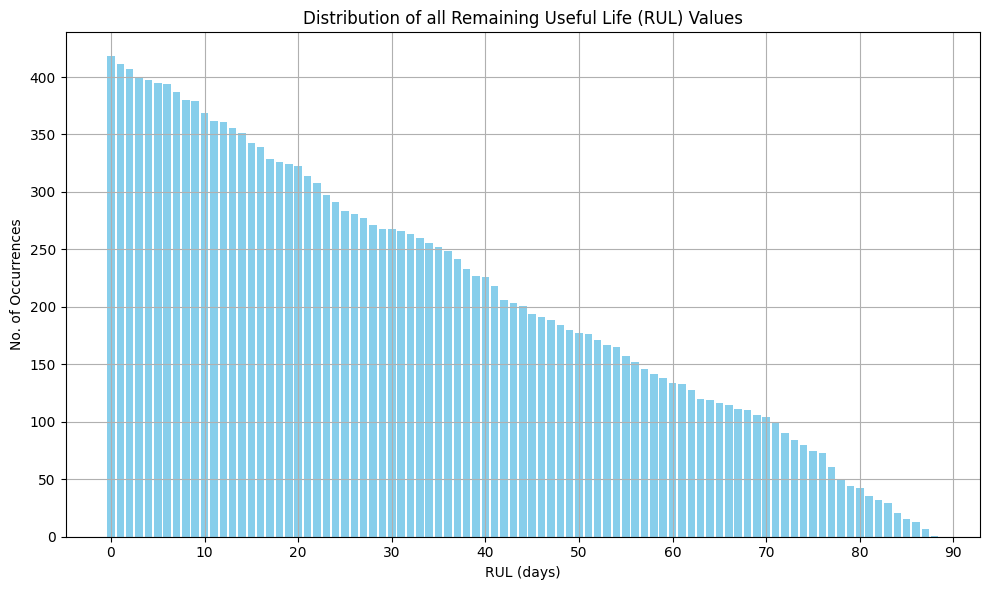

In [8]:
plot_distribution(RUL, 
                  title='Distribution of all Remaining Useful Life (RUL) Values', 
                  xlabel='RUL (days)', 
                  ylabel='No. of Occurrences', 
                  save_path='../img/rul_distribution.png')

### Splitting data

In [27]:
X = df.drop(['date_diff_days'], axis=1).values

In [28]:
y = df['date_diff_days'].values

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Decision Tree

### Sklearn's decision tree regressor

Model: simple tree

CPU times: total: 31.2 ms
Wall time: 45.1 ms


{'MSE': 416.56716108923246,
 'RMSE': 20.409976998743346,
 'MAE': 16.975422685654866,
 'R2 score': 0.06248898603904607}

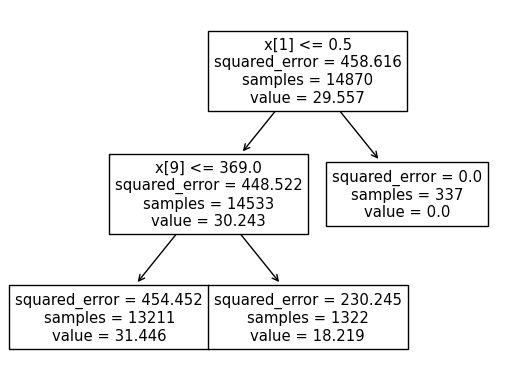

In [12]:
%%time

dtr = DecisionTreeRegressor(max_depth=2, min_samples_split=2)
dtr.fit(X_train, y_train)
plot_tree(dtr)
y_pred = dtr.predict(X_test)

regression_metrics(y_test, y_pred, model_name='simple tree')

### Applying hyperparamater tuning to find the most optimal parameter values

In [13]:
%%time

hyperparameter_values = {'max_depth': [], 'min_samples_split': [], 'mse': [], 'rmse': [], 'mae': [], 'r2': []}

for max_depth in range(2, 41, 2):
    for min_samples_split in range(2, 5, 2):
        tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_samples_split, random_state=0)
        tree.fit(X_train, y_train)
        y_pred = tree.predict(X_test)
        
        mse = calculate_mse(y_test, y_pred)
        rmse = calculate_rmse(y_test, y_pred)
        mae = calculate_mae(y_test, y_pred)
        r2 = calculate_r2(y_test, y_pred)
        
        hyperparameter_values['max_depth'].append(max_depth)
        hyperparameter_values['min_samples_split'].append(min_samples_split)
        hyperparameter_values['mse'].append(mse)
        hyperparameter_values['rmse'].append(rmse)
        hyperparameter_values['mae'].append(mae)
        hyperparameter_values['r2'].append(r2)
        
hyperparameter_df = pd.DataFrame(hyperparameter_values)
hyperparameter_df.sort_values('rmse').head()

CPU times: total: 4.09 s
Wall time: 4.37 s


,max_depth,min_samples_split,mse,rmse,mae,r2
22,24,2,21.713609,4.659786,1.996433,0.951132
26,28,2,21.933827,4.683356,1.971965,0.950637
38,40,2,22.170925,4.708601,2.005917,0.950103
36,38,2,22.170925,4.708601,2.005917,0.950103
34,36,2,22.170925,4.708601,2.005917,0.950103


### Using RandomizedSearchCV for hyperparameter tuning

In [14]:
%%time

param_dist = {
    'max_depth': np.arange(2, 101, 2),
    'min_samples_split': np.arange(2, 21, 2)
}

tree = DecisionTreeRegressor(random_state=0)
random_search = RandomizedSearchCV(tree, param_distributions=param_dist, n_iter=50, scoring='r2', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

regression_metrics(y_test, y_pred_best, model_name='Randomised Tuned Tree')

Best Hyperparameters: {'min_samples_split': 2, 'max_depth': 52}
Model: Randomised Tuned Tree

CPU times: total: 391 ms
Wall time: 6.73 s


{'MSE': 22.170925228617538,
 'RMSE': 4.708601196599425,
 'MAE': 2.0059171597633134,
 'R2 score': 0.9501029160887666}

### Re-training and testing with the best hyperparameters

In [12]:
%%time

dtr = DecisionTreeRegressor(max_depth=24, min_samples_split=2, random_state=0)
dtr.fit(X_train, y_train)
y_pred_dtr = dtr.predict(X_test)

regression_metrics(y_test, y_pred_dtr, model_name='Best Decision Tree')

Model: Best Decision Tree

CPU times: total: 125 ms
Wall time: 148 ms


{'MSE': 21.713608792108754,
 'RMSE': 4.659786346186781,
 'MAE': 1.996433129881893,
 'R2 score': 0.9511321359508683}

### Plotting actual vs predicted values

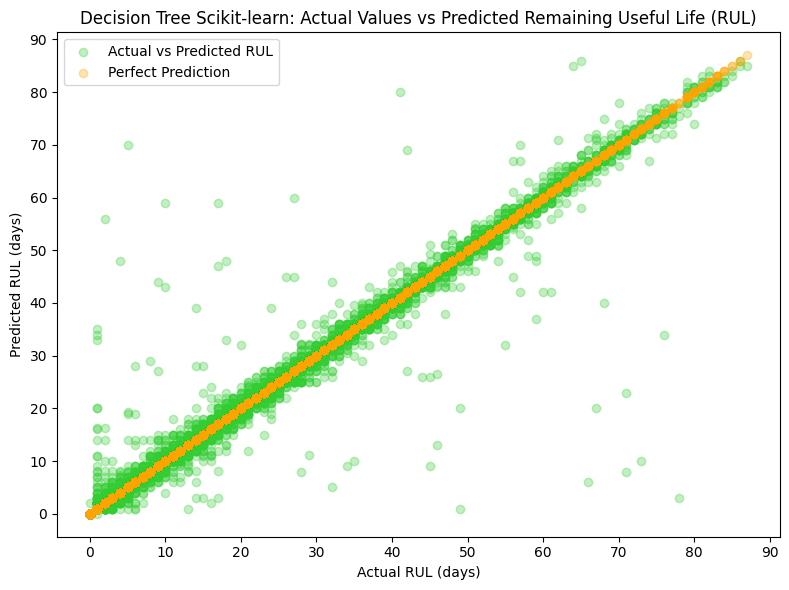

In [13]:
plot_actual_vs_predicted(y_true=y_test, 
                         y_pred=y_pred_dtr, 
                         title="Decision Tree Scikit-learn: Actual Values vs Predicted Remaining Useful Life (RUL)", 
                         save_path='../img/decision_tree_sklearn.png')

### Compare summary statistics

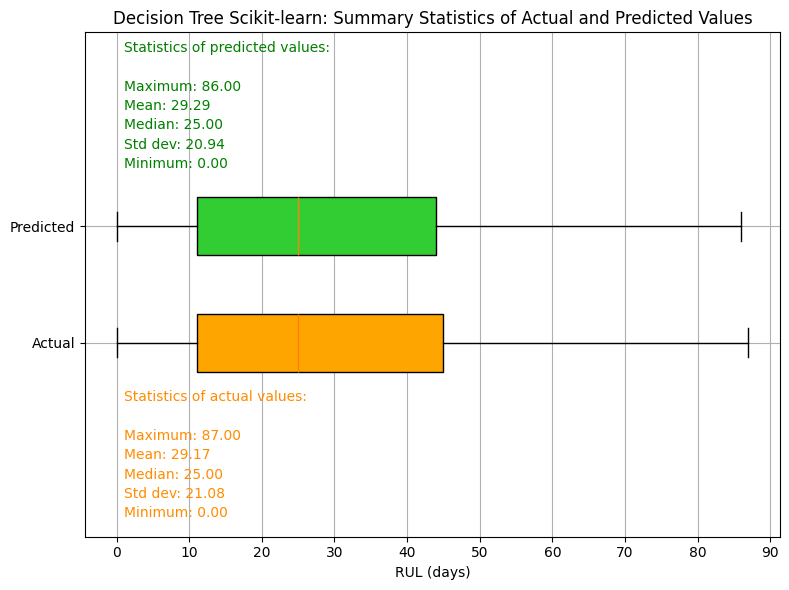

In [14]:
plot_summary_statistics(y_true=y_test, 
                        y_pred=y_pred_dtr,
                        title='Decision Tree Scikit-learn: Summary Statistics of Actual and Predicted Values',
                        save_path='../img/box_plot_decision_tree_sklearn.png')

### Compare RUL distributions

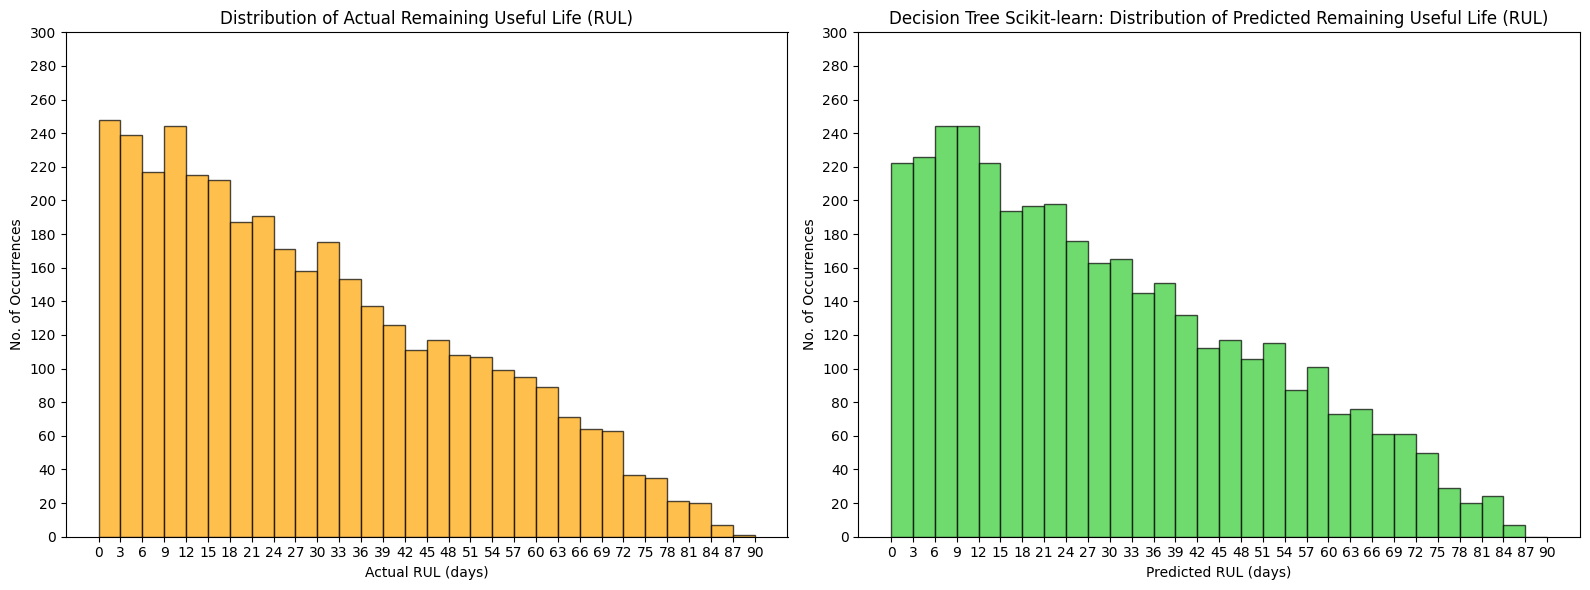

In [15]:
plot_histograms_parallel(y_true=y_test,
                         y_pred=y_pred_dtr,
                         titles=("Distribution of Actual Remaining Useful Life (RUL)", 
                                 "Decision Tree Scikit-learn: Distribution of Predicted Remaining Useful Life (RUL)"),
                         save_path='../img/histogram_parallel_decision_tree_sklearn.png')

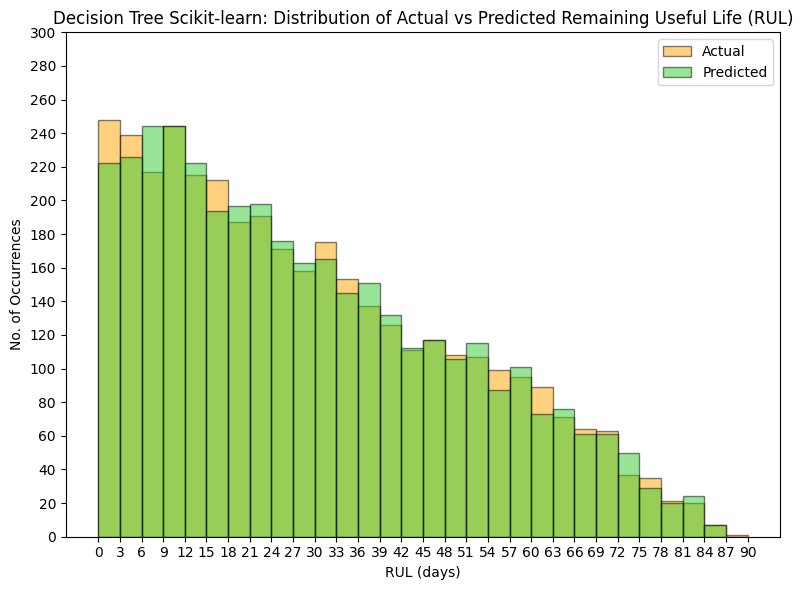

In [16]:
plot_histograms_stacked(y_true=y_test, 
                        y_pred=y_pred_dtr, 
                        title="Decision Tree Scikit-learn: Distribution of Actual vs Predicted Remaining Useful Life (RUL)",
                        save_path='../img/histogram_stacked_tree_sklearn.png')

# Random Forest

### Using RandomizedSearchCV for hyperparameter tuning WITH feature selection

In [23]:
%%time

param_dist = {
    'n_estimators': np.arange(2, 101, 2),
    'max_depth': np.arange(2, 101, 2),
    'min_samples_split': np.arange(2, 21, 2)
}

forest = RandomForestRegressor(max_features='sqrt', random_state=0)
random_search = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=50, scoring='r2', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

regression_metrics(y_test, y_pred_best, model_name='Hyperparameter Tuned Forest')

Best Hyperparameters: {'n_estimators': 88, 'min_samples_split': 2, 'max_depth': 70}
Model: Hyperparameter Tuned Forest

CPU times: total: 3.08 s
Wall time: 52.8 s


{'MSE': 16.13666787632542,
 'RMSE': 4.017047158837623,
 'MAE': 2.4666076226609444,
 'R2 score': 0.9636833978388316}

### Using RandomizedSearchCV for hyperparameter tuning WITHOUT feature selection

In [24]:
%%time

param_dist = {
    'n_estimators': np.arange(2, 101, 2),
    'max_depth': np.arange(2, 101, 2),
    'min_samples_split': np.arange(2, 21, 2)
}

forest = RandomForestRegressor(random_state=0)
random_search = RandomizedSearchCV(forest, param_distributions=param_dist, n_iter=50, scoring='r2', n_jobs=-1, random_state=0)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
y_pred_best = best_model.predict(X_test)

best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

regression_metrics(y_test, y_pred_best, model_name='Hyperparameter Tuned Forest')

Best Hyperparameters: {'n_estimators': 88, 'min_samples_split': 2, 'max_depth': 70}
Model: Hyperparameter Tuned Forest

CPU times: total: 10.9 s
Wall time: 4min 10s


{'MSE': 9.254783499089097,
 'RMSE': 3.042167565912354,
 'MAE': 1.6106094129258466,
 'R2 score': 0.9791715183704518}

### Re-training and testing with the best hyperparameters

In [18]:
%%time

rfr = RandomForestRegressor(n_estimators=88, max_depth=70, min_samples_split=2, max_features='sqrt', random_state=0)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

regression_metrics(y_test, y_pred_rfr, model_name='Best Random Forest with feature selection')

Model: Best Random Forest with feature selection

CPU times: total: 2.2 s
Wall time: 2.33 s


{'MSE': 16.13666787632542,
 'RMSE': 4.017047158837623,
 'MAE': 2.4666076226609444,
 'R2 score': 0.9636833978388316}

In [17]:
%%time

rfr = RandomForestRegressor(n_estimators=88, max_depth=70, min_samples_split=2, random_state=0)
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_test)

regression_metrics(y_test, y_pred_rfr, model_name='Best Random Forest')

Model: Best Random Forest

CPU times: total: 8.39 s
Wall time: 8.96 s


{'MSE': 9.254783499089097,
 'RMSE': 3.042167565912354,
 'MAE': 1.6106094129258466,
 'R2 score': 0.9791715183704518}

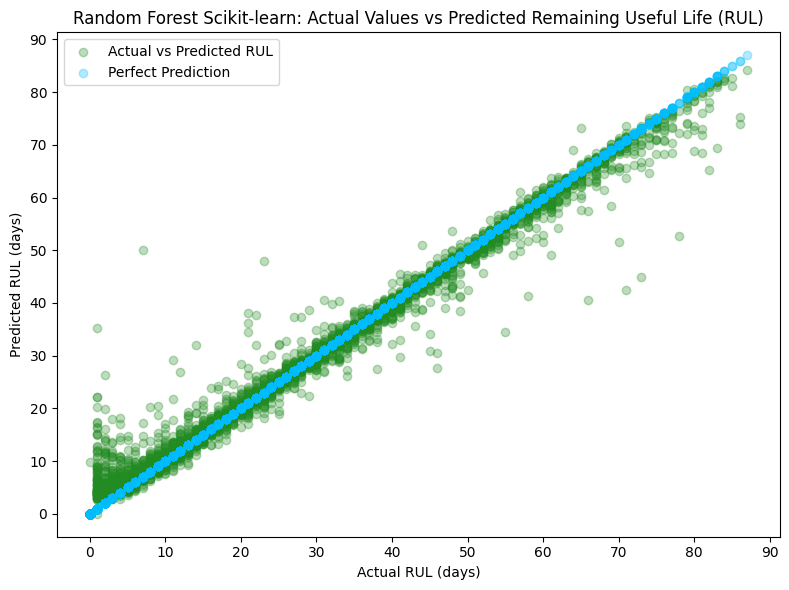

In [18]:
plot_actual_vs_predicted(y_true=y_test, 
                         y_pred=y_pred_rfr, 
                         title="Random Forest Scikit-learn: Actual Values vs Predicted Remaining Useful Life (RUL)", 
                         true_color='deepskyblue', 
                         predicted_color='forestgreen',
                         save_path='../img/random_forest_sklearn.png')

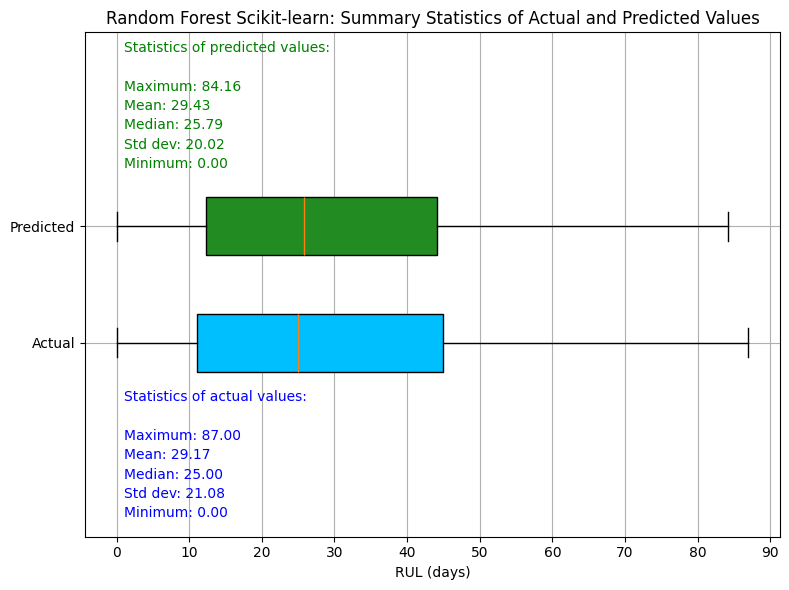

In [19]:
plot_summary_statistics(y_true=y_test, 
                        y_pred=y_pred_rfr,
                        title='Random Forest Scikit-learn: Summary Statistics of Actual and Predicted Values',
                        true_color='deepskyblue', 
                        pred_color='forestgreen', 
                        text_color_t='blue', 
                        text_color_p='green', 
                        save_path='../img/box_plot_random_forest_sklearn.png')

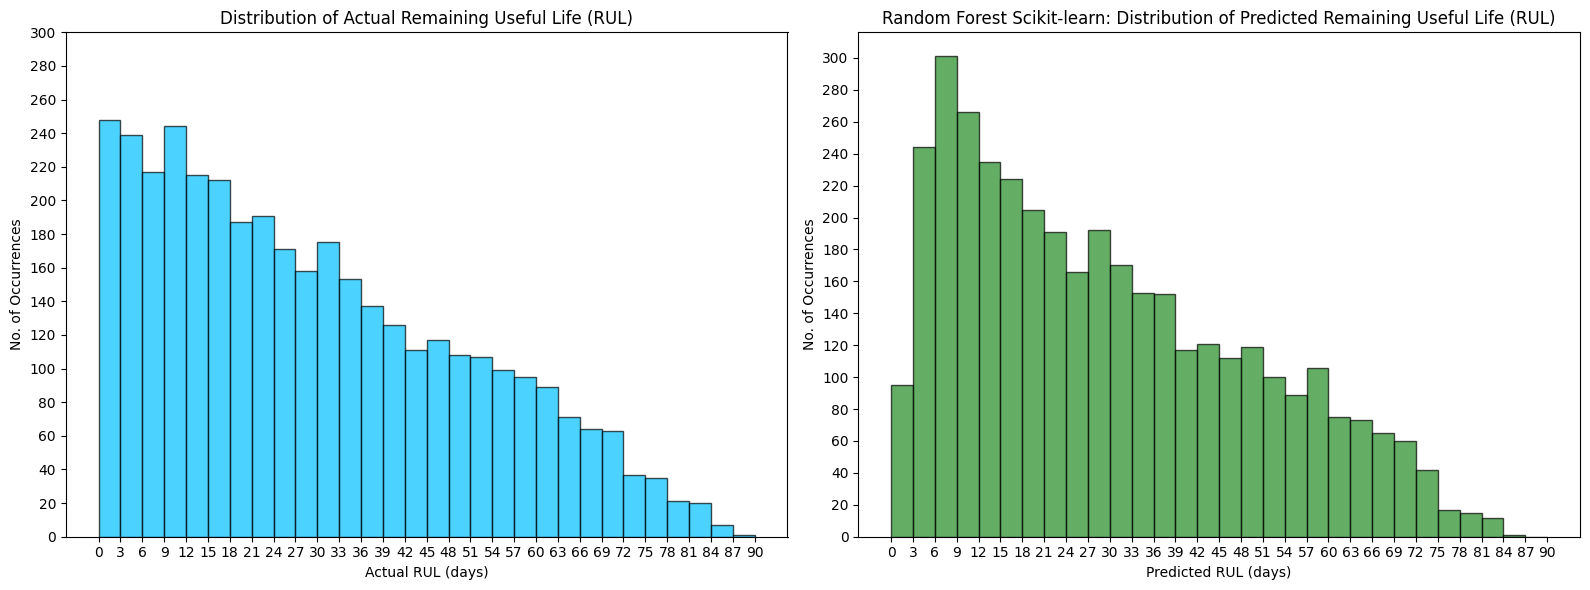

In [20]:
plot_histograms_parallel(y_true=y_test, 
                         y_pred=y_pred_rfr,
                         titles=("Distribution of Actual Remaining Useful Life (RUL)", 
                                 "Random Forest Scikit-learn: Distribution of Predicted Remaining Useful Life (RUL)"),
                         colors=('deepskyblue', 'forestgreen'),
                         save_path='../img/histogram_parallel_random_forest_sklearn.png')

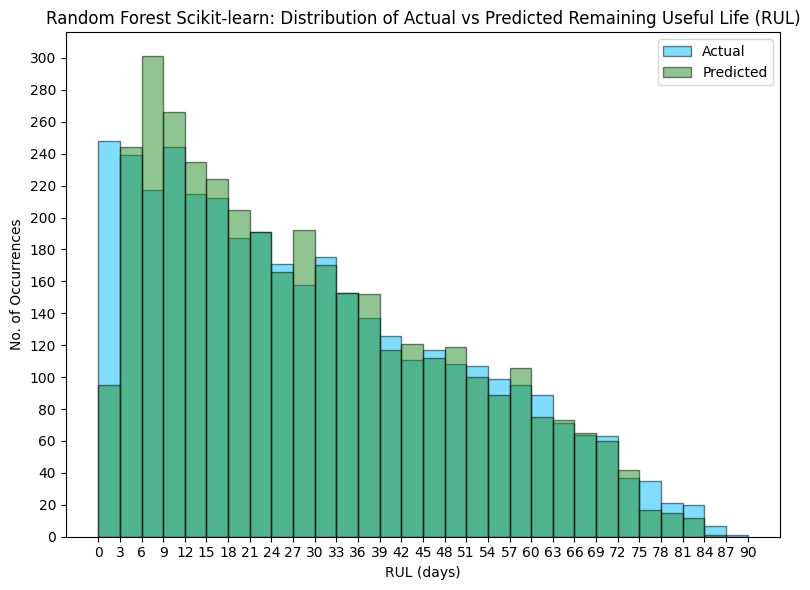

In [21]:
plot_histograms_stacked(y_true=y_test, 
                         y_pred=y_pred_rfr, 
                         title="Random Forest Scikit-learn: Distribution of Actual vs Predicted Remaining Useful Life (RUL)",
                         actual_color='deepskyblue', 
                         predicted_color='forestgreen',
                         save_path='../img/histogram_stacked_random_forest_sklearn.png')

## Calculating time complexity

### Splitting the data from 10% to 90% of its original train set size

In [12]:
X_1, X_9, y_1, y_9 = train_test_split(X_train, y_train, test_size=0.9, random_state=0)
X_2, X_8, y_2, y_8 = train_test_split(X_train, y_train, test_size=0.8, random_state=0)
X_3, X_7, y_3, y_7 = train_test_split(X_train, y_train, test_size=0.7, random_state=0)
X_4, X_6, y_4, y_6 = train_test_split(X_train, y_train, test_size=0.6, random_state=0)
X_5, _, y_5, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=0)

### Decision tree

In [16]:
dtr = DecisionTreeRegressor(max_depth=10, min_samples_split=2)

# Dictionary to store average training times for each split
average_training_times_dt = {}

# Loop over different splits (10% to 90%)
for i in range(1, 10):
    # List to store training times for each trial
    training_times = []
    
    for trial in range(3):
        start_time = time.time()
        X_train = globals()['X_' + str(i)]
        y_train = globals()['y_' + str(i)]
        dtr.fit(X_train, y_train)
        training_times.append(time.time() - start_time)
    
    # Calculate average training time for the current split
    average_training_time = sum(training_times) / len(training_times)
    
    # Store average training time for the current split
    average_training_times_dt[f'{i}0%'] = average_training_time

In [17]:
average_training_times_dt

{'10%': 0.01041706403096517,
 '20%': 0.015752474466959637,
 '30%': 0.028548717498779297,
 '40%': 0.03425908088684082,
 '50%': 0.03658930460611979,
 '60%': 0.0522153377532959,
 '70%': 0.05765446027119955,
 '80%': 0.06290793418884277,
 '90%': 0.06818135579427083}

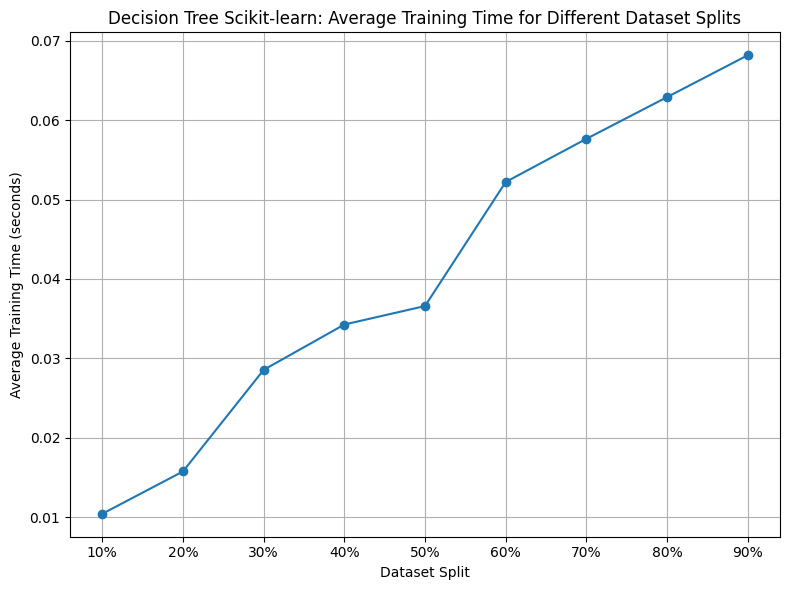

In [34]:
plt.figure(figsize=(8, 6))
plt.plot(list(average_training_times_dt.keys()), list(average_training_times_dt.values()), marker='o')
plt.xlabel('Dataset Split')
plt.ylabel('Average Training Time (seconds)')
plt.title("Decision Tree Scikit-learn: Average Training Time for Different Dataset Splits")
plt.grid(True)
plt.tight_layout()
plt.savefig('../img/time_complexity_decision_tree_sklearn.png')
plt.show()

### Random Forest (with feature selection)

In [44]:
rfr = RandomForestRegressor(n_estimators=3, max_depth=10, min_samples_split=2, max_features='sqrt')

# Dictionary to store average training times for each split
average_training_times_rf = {}

# Loop over different splits (10% to 90%)
for i in range(1, 10):
    # List to store training times for each trial
    training_times = []
    
    for trial in range(3):
        start_time = time.time()
        X_train = globals()['X_' + str(i)]
        y_train = globals()['y_' + str(i)]
        rfr.fit(X_train, y_train)
        training_times.append(time.time() - start_time)
    
    # Calculate average training time for the current split
    average_training_time = sum(training_times) / len(training_times)
    
    # Store average training time for the current split
    average_training_times_rf[f'{i}0%'] = average_training_time

In [45]:
average_training_times_rf

{'10%': 0.005345821380615234,
 '20%': 0.010419527689615885,
 '30%': 0.015624602635701498,
 '40%': 0.01579395929972331,
 '50%': 0.02354089419047038,
 '60%': 0.01835497220357259,
 '70%': 0.026241461435953777,
 '80%': 0.02623097101847331,
 '90%': 0.031422058741251625}

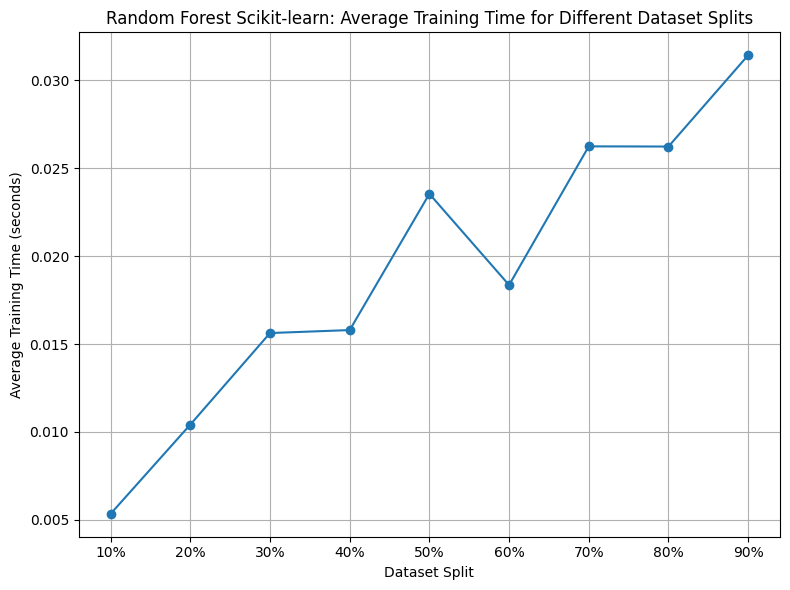

In [47]:
plt.figure(figsize=(8, 6))
plt.plot(list(average_training_times_rf.keys()), list(average_training_times_rf.values()), marker='o')
plt.xlabel('Dataset Split')
plt.ylabel('Average Training Time (seconds)')
plt.title("Random Forest Scikit-learn: Average Training Time for Different Dataset Splits")
plt.grid(True)
plt.tight_layout()
plt.savefig('../img/time_complexity_random_forest_sklearn.png')
plt.show()